## Paragraph Embedding (Doc2Vec) Demo

Doc2Vec [Li, Mikolov 2014](https://arxiv.org/pdf/1405.4053v2.pdf) is a generalization of Word2Vec, with embeddings that can be extended to paragraphs or documents. With this technique, we can use a measure of distance between two documents, assess their similarity and use for clustering or classification.

Using the original community art center dataset is problematic here since we only have 251 English language documents (document: mission statements from a center). We used the padded dataset and we also used a pretrained model that we updated with our data to see if we could leverage some information contained in a general dataset (the dataset was a sample of news articles). We then did clustering with k-means and assessed the fitness of the model using silhouette, a measure of validation of consistency within the data clusters. The silhouette value ranges between (-1, 1) and measures the similarity of an object to its assigned cluster compared to the other clusters. High values indicate that the clusters are well separated and well defined. Here we measured average silhouette values for different numbers of clusters to identify the best one. If there are too many outliers, we might get a skewed reading of the fit - assessing the results of Doc2Vec for unsupervised learning is difficult and usually requires human assistance.

At this time, Gensim does not support prediction with Doc2Vec - we can only check the similarity between documents that were contained in the training set, which may lead to overfitting. 

<hr/>

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) # may trigger a deprecation warning 

import pandas as pd
import numpy as np
from prettytable import PrettyTable

import random
import time 
start_time = time.time()
start_cpu = time.process_time()

import gensim
from textblob import TextBlob
import json

import multiprocessing
cores = multiprocessing.cpu_count() # number of available cores

# local modules
from helper.helper_funs import time_filename, save_folder_file, logged
from methods.word_doc2vec import doc2vec_model, plot_d2v, pretrained_doc2vec, silhouette_plots

from helper.dk_ipython import toggled, one_cell_toggle

assert gensim.models.doc2vec.FAST_VERSION > -1, "Multiprocessor doc2vec will be slow without fast version"

one_cell_toggle()

### Get tuneable parameters and cleaned data, make a log file

In [2]:
with open('changeable_parameters/tuning_params.json') as json_file:  
    tune_params = json.load(json_file)
    
with open('data/processed_data/cleaned_data.json') as json_data:  
    all_data = json.load(json_data)
    
one_cell_toggle()    

In [3]:
all_donnees = all_data['all_donnees']
all_labs = all_data['all_labels']
processed_data = all_data['processed_data']

all_kwargs = tune_params['set_kwargs']
kwargs_d2v = all_kwargs['kwargs_d2v']

lda_table_path = 'results/lda_table_path.csv'
pretrained_emb = "../pretrained_models/apnews_dbow/doc2vec.bin"

one_cell_toggle()    

In [4]:
to_log = True               # set to True to get log files
seed = all_data['generating_params']['seed']
stemmer = all_data['generating_params']['stemmer']

random.seed(seed)
workers = cores
n_clusters = 4            # number of clusters in 2D projection
epochs_d2v = 100          # number of epochs
top_n = 20                # number of top words to show
with_adjust_text = False  # smart distribution of words on scatterplot: warning -- much slower if True
# Note: adjust_text does not render well with sentence graphs

one_cell_toggle()    

In [5]:
if to_log:
    full_path_log = logged(filename='doc2vec')

<hr/>

### Viewing Hand Tunable Doc2Vec parameters as specified on [tuning_params.json](changeable_parameters/tuning_params.json) file

<hr/>

<br/>

**Clear definitions of each manually-tuned Word2Vec parameters are available in the file, under the key `help_kwargsd2v`.** 

One can fetch individual definitions for reference, or all parameter details can be displayed as below:

<br/>

In [6]:
'''
Note: if more info is needed about the tunable parameters, type help_kwargs... with the parameter number
Example:
'''
x = PrettyTable()
x.title = "Hand tunable parameters - Doc2Vec"
fieldnames = ["Parameter", "Data Type", "Definition"]
x.field_names = fieldnames

for fname in fieldnames:    
    x.align[fname] = "l"     

[x.add_row([key, val[0], val[1]]) for key, val in all_kwargs['help_kwargs_d2v'].items()]

print(x)

one_cell_toggle()

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                      Hand tunable parameters - Doc2Vec                                                                                                       |
+--------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Parameter    | Data Type | Definition                                                                                                                                                                                                        |
+--------------+-----------+--------

### Train Doc2Vec from scratch

In [7]:
# Train Basic Doc2Vec
text_labels = ["{}...".format(all_donnees[doc][:25]) for doc in range(len(all_donnees))]
# label docs with id numbers from 0 to len(labels)
all_labs = list(np.arange(len(processed_data)))

one_cell_toggle()    

In [8]:
trained_doc2vec = doc2vec_model(processed_data, 
                                all_labs, 
                                workers = cores, 
                                epochs = epochs_d2v, 
                                save_as_word2vec = False, 
                                **kwargs_d2v)

In [9]:
tab_idx = pd.read_csv(lda_table_path)


d2v_results_dict = {"topic": [idx + 1 for idx in range(n_clusters)],
                    "best_missions_lda":[tab_idx.Mission[top][:230] for top in range(n_clusters)],
                    "closest_doc2vec":  
                    [all_donnees[trained_doc2vec.docvecs.most_similar(
                                 tab_idx['index'][top])[0][0]][:230] for top in range(n_clusters)]}

d2v_results_df = pd.DataFrame(d2v_results_dict)
path = save_folder_file('results', 'd2v_compared_lda', ext='.csv')

d2v_results_df.to_csv(path)

one_cell_toggle()    

In [10]:
d2v_results_df

,topic,best_missions_lda,closest_doc2vec
0,1,through august the community of jackson hole w...,the woodland cultural centre is a first nation...
1,2,allied arts is oklahomas only united arts fund...,harbourfront centre on toronto's waterfront is...
2,3,theater company outreach has launched heroes s...,hamilton youth poets hyp was created in to giv...
3,4,artistic mission and profile of the organizati...,some assembly advances education and the publi...


In [11]:
for top in range(n_clusters):
    print("TOPIC {}:\n\t***\nHighest ranking document with LDA:\n{}\n\t***\n".format(top+1, d2v_results_df.best_missions_lda[top]))
    print("Most similar document picked by Doc2Vec:\n{}\n\n".format(d2v_results_df.closest_doc2vec[top]))
    
one_cell_toggle()        

TOPIC 1:
	***
Highest ranking document with LDA:
through august the community of jackson hole wyoming is welcome to participate in an event along north cache street a major roadway connecting downtown jackson hole to the countrys national parks the event which will feature inter
	***

Most similar document picked by Doc2Vec:
the woodland cultural centre is a first nations educational and cultural centre it was established in to protect promote interpret and present the history language intellect and cultural heritage of the anishinaabe and onkwehon we


TOPIC 2:
	***
Highest ranking document with LDA:
allied arts is oklahomas only united arts fund uaf and is dedicated to raising financial support and advancing the arts in central oklahoma since allied arts has raised more than million in support for the communitys arts and cult
	***

Most similar document picked by Doc2Vec:
harbourfront centre on toronto's waterfront is an innovative non-profit cultural organization that creates events

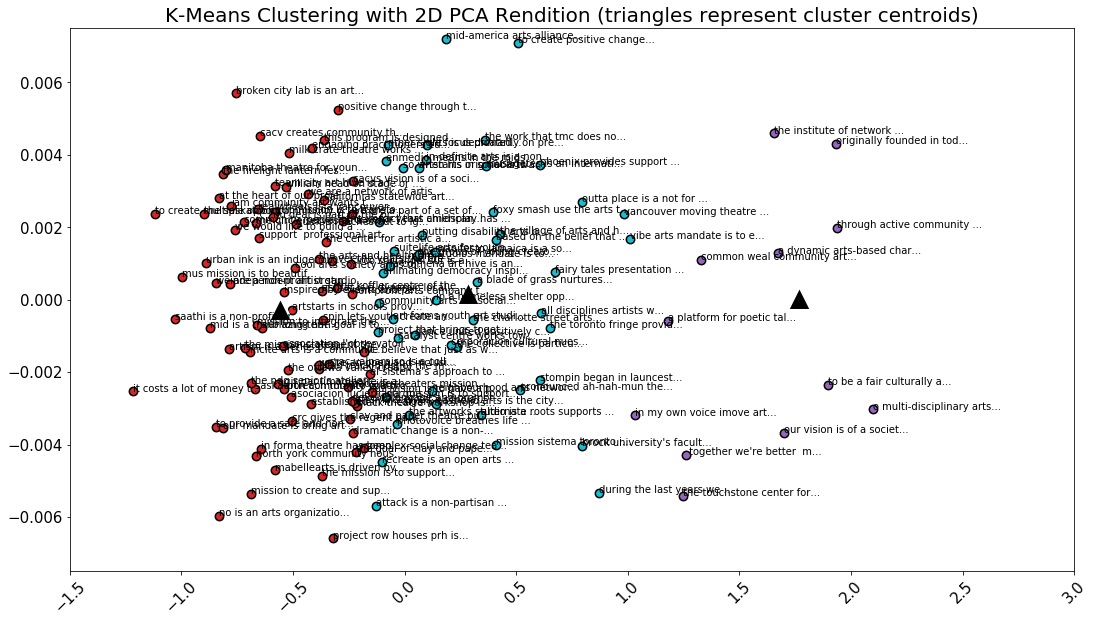

In [26]:
plot_d2v(trained_doc2vec, text_labels, 
                          max_idx=150, 
                          n_clusters = n_clusters,
                          xlim=(-1.5,3),
                          ylim=(-0.0075,0.0075),
                          with_adjust_text=with_adjust_text,
                          random_state=8920)

### Compare previous results with a pretrained model:

In [13]:
pretrained_d2v_model = pretrained_doc2vec(processed_data, 
                                          labels=all_labs, 
                                          pretrained_emb=pretrained_emb,
                                          epochs=epochs_d2v,
                                          workers=cores,
                                          **kwargs_d2v)

In [14]:
pred2v_results_dict = {"topic": [idx + 1 for idx in range(n_clusters)],
                    "best_missions_lda":[tab_idx.Mission[top][:230] for top in range(n_clusters)],
                    "closest_doc2vec":  
                    [all_donnees[pretrained_d2v_model.docvecs.most_similar(
                                 tab_idx['index'][top])[0][0]][:230] for top in range(n_clusters)]}

pred2v_results_df = pd.DataFrame(d2v_results_dict)
path = save_folder_file('results', 'pretrained_d2v_compared_lda', ext='.csv')

pred2v_results_df.to_csv(path)
one_cell_toggle()    

In [15]:
pred2v_results_df

,topic,best_missions_lda,closest_doc2vec
0,1,through august the community of jackson hole w...,the woodland cultural centre is a first nation...
1,2,allied arts is oklahomas only united arts fund...,harbourfront centre on toronto's waterfront is...
2,3,theater company outreach has launched heroes s...,hamilton youth poets hyp was created in to giv...
3,4,artistic mission and profile of the organizati...,some assembly advances education and the publi...


In [16]:
for top in range(n_clusters):
    print("TOPIC {}:\n\t***\nHighest ranking document with LDA:\n{}\n\t***\n".format(top+1, pred2v_results_df.best_missions_lda[top]))
    print("Most similar document picked by Doc2Vec:\n{}\n\n".format(pred2v_results_df.closest_doc2vec[top]))
    
one_cell_toggle()        

TOPIC 1:
	***
Highest ranking document with LDA:
through august the community of jackson hole wyoming is welcome to participate in an event along north cache street a major roadway connecting downtown jackson hole to the countrys national parks the event which will feature inter
	***

Most similar document picked by Doc2Vec:
the woodland cultural centre is a first nations educational and cultural centre it was established in to protect promote interpret and present the history language intellect and cultural heritage of the anishinaabe and onkwehon we


TOPIC 2:
	***
Highest ranking document with LDA:
allied arts is oklahomas only united arts fund uaf and is dedicated to raising financial support and advancing the arts in central oklahoma since allied arts has raised more than million in support for the communitys arts and cult
	***

Most similar document picked by Doc2Vec:
harbourfront centre on toronto's waterfront is an innovative non-profit cultural organization that creates events

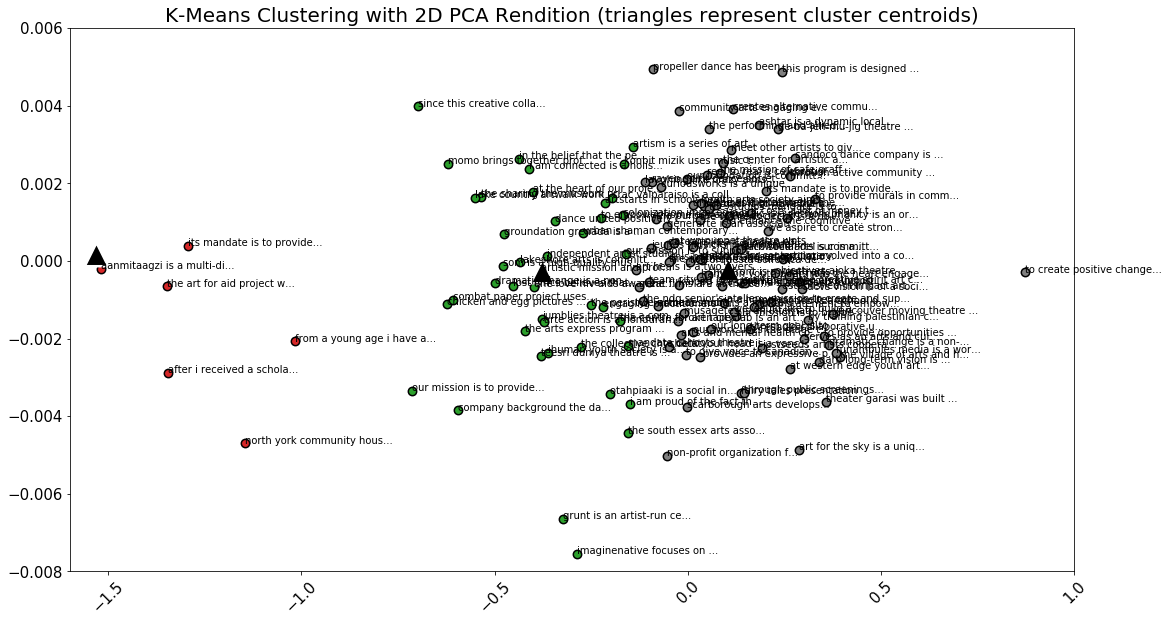

In [24]:
plot_d2v(pretrained_d2v_model, text_labels, 
                               max_idx=150,
                               n_clusters = n_clusters,
                               xlim=(-1.6, 1.0),
                               ylim=(-0.008,0.006),
                               with_adjust_text=with_adjust_text,
                               random_state=470)

one_cell_toggle()

### Model Validation using averaged Silhouette values

To find 'best' number of clusters to separate.

For n_clusters = 3 The average silhouette_score is : 0.60932314
For n_clusters = 4 The average silhouette_score is : 0.57519346
For n_clusters = 5 The average silhouette_score is : 0.5677658
For n_clusters = 6 The average silhouette_score is : 0.5386865
For n_clusters = 7 The average silhouette_score is : 0.52444845


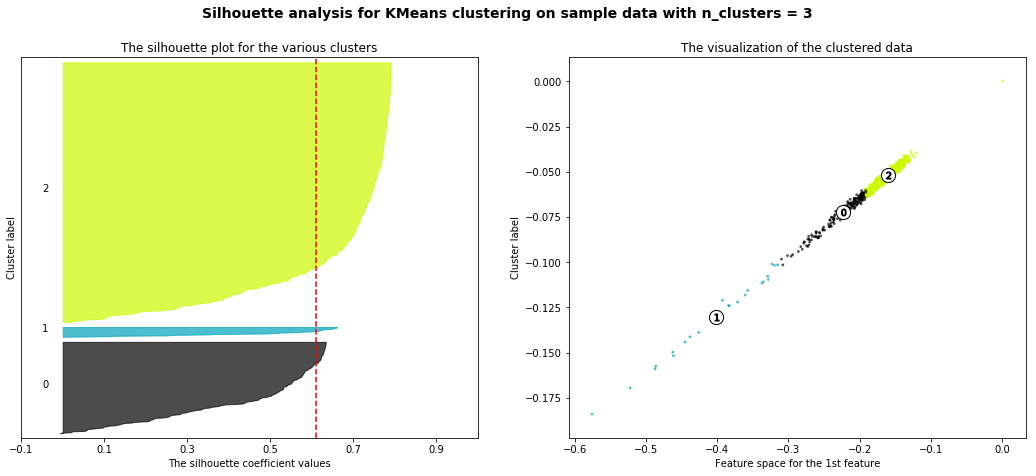

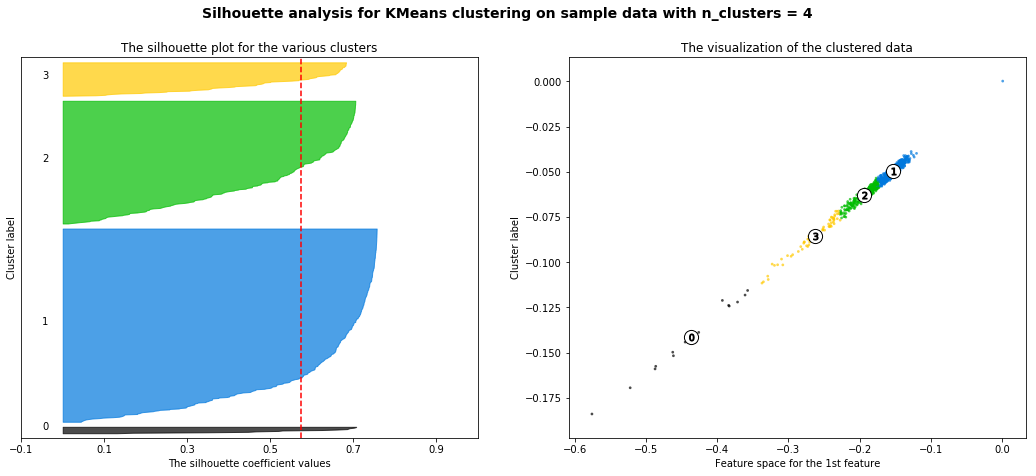

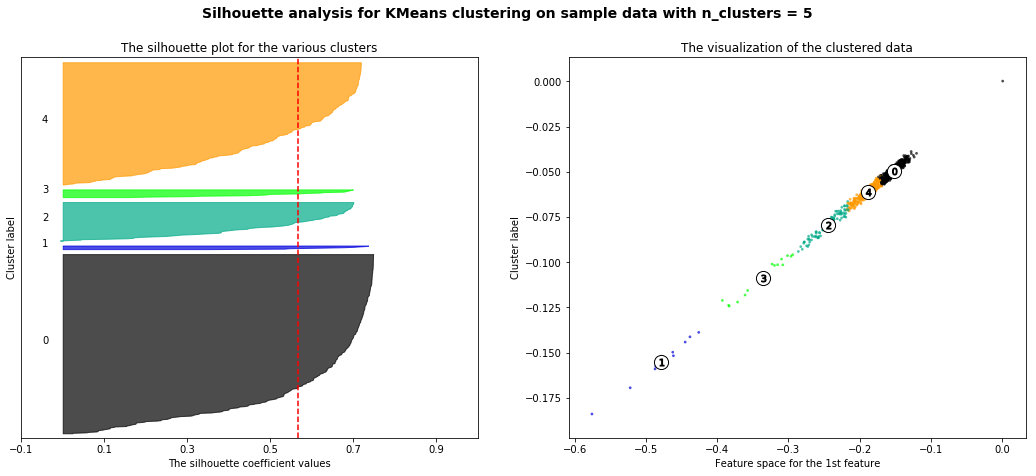

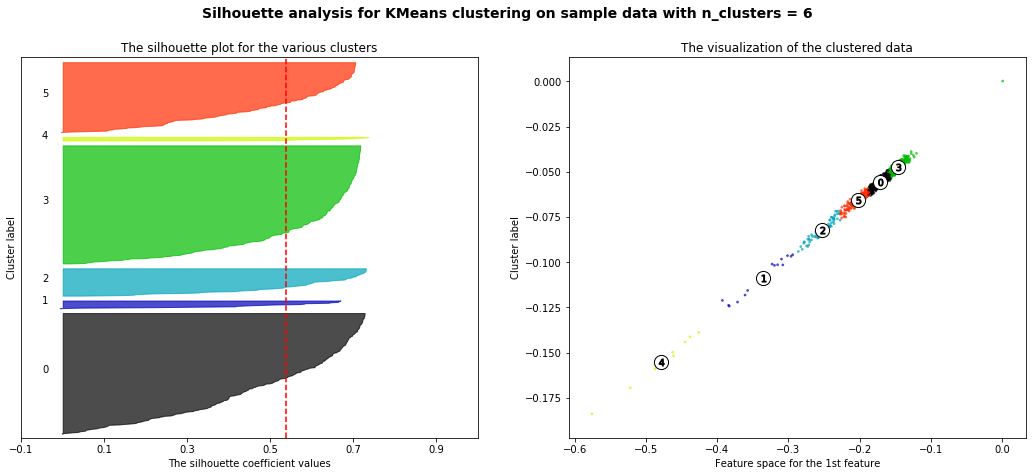

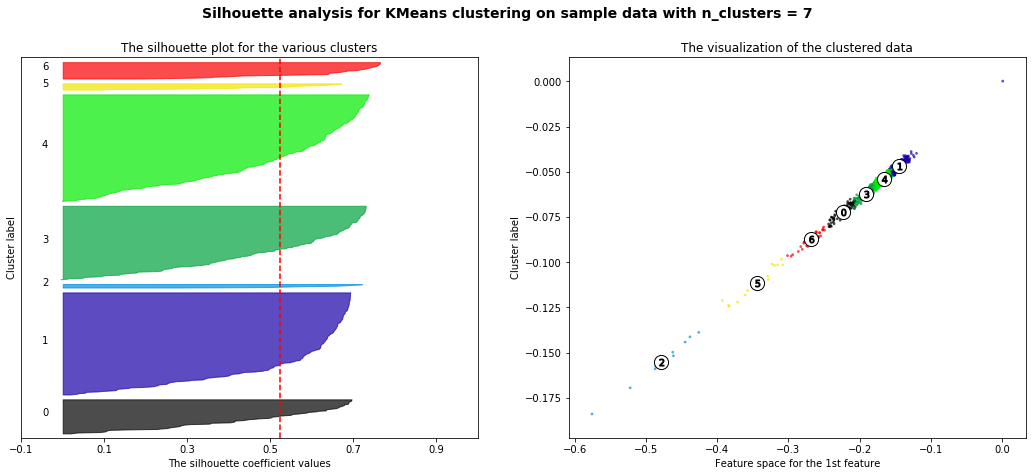

In [18]:
silhouette_plots(trained_doc2vec)

In [19]:
end_time = time.time()
end_cpu = time.process_time()

time_taken = end_time - start_time
cpu_time = end_cpu - start_cpu
print('Time elapsed to run code:{}\nCPU time elapsed:{}'.format(time_taken, cpu_time))

Time elapsed to run code:49.442341804504395
CPU time elapsed:59.267562
